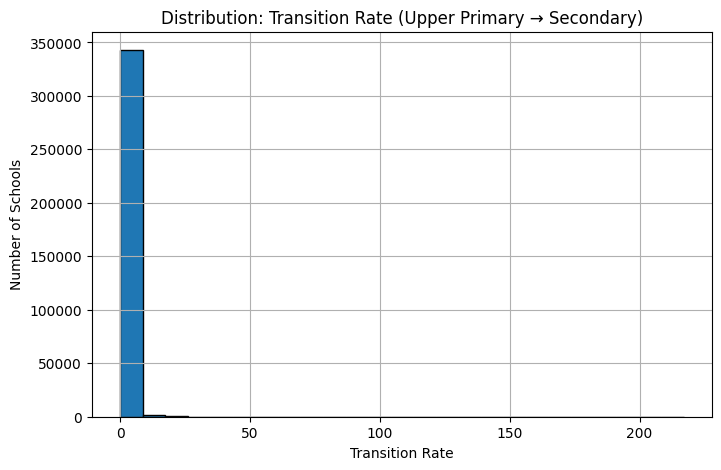

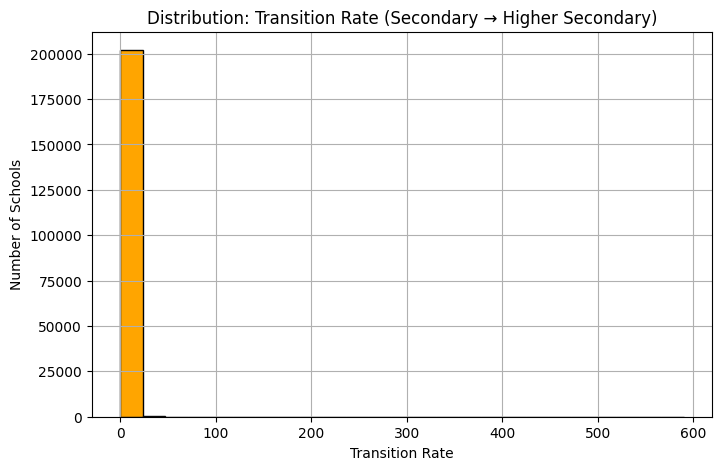

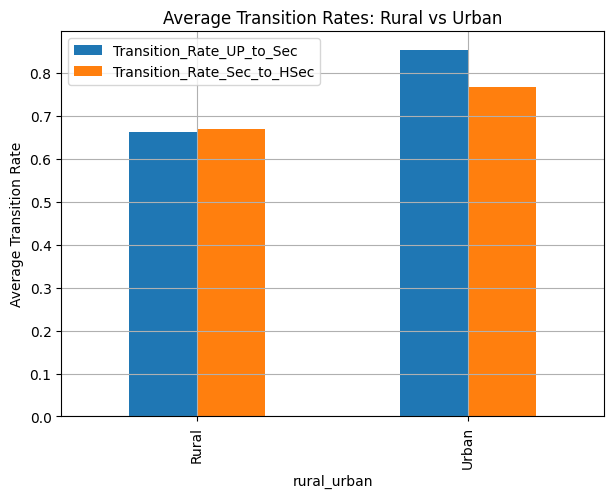

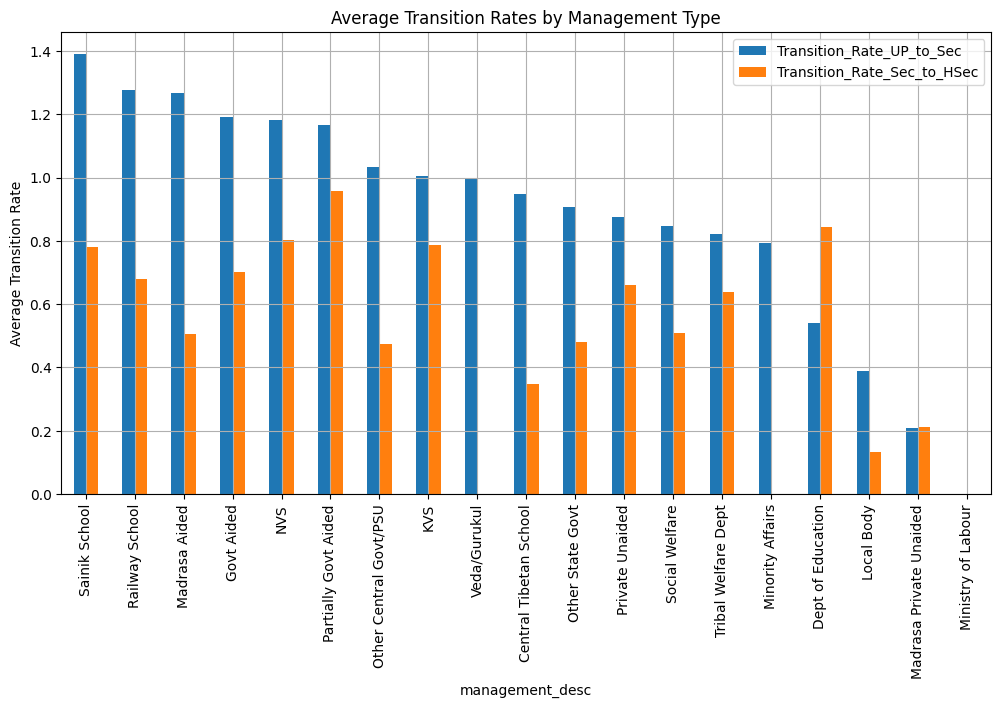

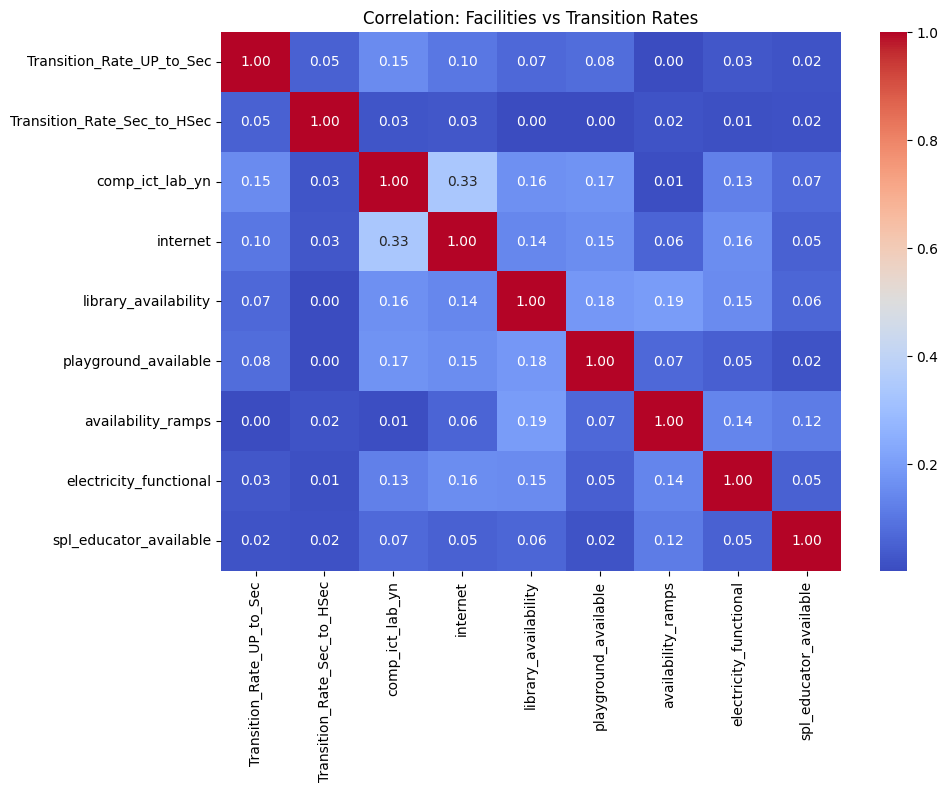

 Bottom 10 Districts — Upper Primary → Secondary:
                 state                district  Transition_Rate_UP_to_Sec
37   ARUNACHAL PRADESH            KURUNG KUMEY                        0.0
36   ARUNACHAL PRADESH                KRA DADI                        0.0
444            MANIPUR                 KAMJONG                        0.0
446            MANIPUR                   NONEY                        0.0
465            MIZORAM               HNAHTHIAL                        0.0
466            MIZORAM                KHAWZAWL                        0.0
462          MEGHALAYA        WEST KHASI HILLS                        0.0
459          MEGHALAYA  SOUTH WEST KHASI HILLS                        0.0
468            MIZORAM               LAWNGTLAI                        0.0
477           NAGALAND                LONGLENG                        0.0

 Bottom 10 Districts — Secondary → Higher Secondary:
                 state                district  Transition_Rate_Sec_to_HSec
35   A

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

enr1_23_24 = pd.read_csv("100_enr1_23.csv")
enr1_24_25 = pd.read_csv("100_enr1.csv")
fac_24_25 = pd.read_csv("100_fac.csv")
prof1_24_25 = pd.read_csv("100_prof1.csv")
prof2_24_25 = pd.read_csv("100_prof2.csv")

# Function to filter and compute total enrollment across all grades
def filter_total_enrollment(df):
    df_total = df[(df["item_group"] == 1) & (df["item_id"] == 1)].copy()
    for c in range(1, 13):  # sum boys + girls for each class
        df_total[f"c{c}_total"] = df_total[f"c{c}_b"] + df_total[f"c{c}_g"]
    cols = ["pseudocode"] + [f"c{c}_total" for c in range(1, 13)]
    df_total = df_total[cols].groupby("pseudocode", as_index=False).sum()
    return df_total

# Computing enrollment totals for both years and merge 
enr_total_23 = filter_total_enrollment(enr1_23_24)
enr_total_24 = filter_total_enrollment(enr1_24_25)
enr_total_23.columns = ["pseudocode"] + [f"c{c}_23_24" for c in range(1, 13)]
enr_total_24.columns = ["pseudocode"] + [f"c{c}_24_25" for c in range(1, 13)]
enrollment_data = pd.merge(enr_total_23, enr_total_24, on="pseudocode", how="inner")

# Calculate transition rates between key schooling stages 
enrollment_data["Transition_Rate_UP_to_Sec"] = (
    enrollment_data["c9_24_25"] / enrollment_data["c8_23_24"].replace(0, np.nan)
)
enrollment_data["Transition_Rate_Sec_to_HSec"] = (
    enrollment_data["c11_24_25"] / enrollment_data["c10_23_24"].replace(0, np.nan)
)
enrollment_data.replace([np.inf, -np.inf], np.nan, inplace=True)
transition_df = enrollment_data[["pseudocode", "Transition_Rate_UP_to_Sec", "Transition_Rate_Sec_to_HSec"]].copy()

# Clean and transform facility-level data 
fac_cols = [
    "pseudocode","total_boys_func_toilet","total_girls_func_toilet",
    "comp_ict_lab_yn","internet","electricity_availability",
    "library_availability","playground_available","availability_ramps",
    "spl_educator_yn","desktop","laptop","digiboard","smart_class_tv_tot"
]
fac_df = fac_24_25[fac_cols].copy()
bool_cols = ["comp_ict_lab_yn","internet","library_availability","playground_available","availability_ramps"]
for col in bool_cols:
    fac_df[col] = fac_df[col].replace({1:1,2:0,9:np.nan})
fac_df["electricity_functional"] = fac_df["electricity_availability"].replace({1:1,2:0,3:0,9:np.nan})
fac_df["spl_educator_available"] = fac_df["spl_educator_yn"].replace({1:1,2:1,3:0,9:np.nan})
fac_df["total_func_toilets"] = fac_df["total_boys_func_toilet"].fillna(0) + fac_df["total_girls_func_toilet"].fillna(0)
fac_df.drop(columns=["electricity_availability","spl_educator_yn"], inplace=True)

# Merge profiles and infrastructure with transition data 
prof1_cols = ["pseudocode","state","district","rural_urban","managment","lowclass","highclass"]
prof1_df = prof1_24_25[prof1_cols].copy()
prof1_df["rural_urban"] = prof1_df["rural_urban"].replace({1:"Rural",2:"Urban"})
prof2_cols = ["pseudocode","smc_exists","smc_smdc_meetings","grants_receipt"]
prof2_df = prof2_24_25[prof2_cols].copy()
prof2_df["smc_exists"] = prof2_df["smc_exists"].replace({1:1,2:0,9:np.nan})

school_df = (
    transition_df
    .merge(prof1_df, on="pseudocode", how="left")
    .merge(fac_df, on="pseudocode", how="left")
    .merge(prof2_df, on="pseudocode", how="left")
)

# Map management codes to descriptive labels
management_map = {
    1:'Dept of Education', 2:'Tribal Welfare Dept', 3:'Local Body', 4:'Govt Aided',
    5:'Private Unaided', 6:'Other State Govt', 7:'Partially Govt Aided',
    89:'Minority Affairs', 90:'Social Welfare', 91:'Ministry of Labour',
    92:'KVS', 93:'NVS', 94:'Sainik School', 95:'Railway School', 96:'Central Tibetan School',
    97:'Madrasa Private Unaided', 99:'Madrasa Aided', 101:'Other Central Govt/PSU', 102:'Veda/Gurukul'
}
school_df["management_desc"] = school_df["managment"].map(management_map)

# Summarize transition performance by district 
district_summary = (
    school_df.groupby(["state","district"])
    [["Transition_Rate_UP_to_Sec","Transition_Rate_Sec_to_HSec"]]
    .mean().reset_index()
)
district_summary.to_csv("district_transition_summary.csv", index=False)
school_df.to_csv("transition_bottlenecks_school.csv", index=False)

# Visualization: distribution of transition rates 
plt.figure(figsize=(8,5))
plt.hist(school_df["Transition_Rate_UP_to_Sec"].dropna(), bins=25, edgecolor='black')
plt.title("Distribution: Transition Rate (Upper Primary → Secondary)")
plt.xlabel("Transition Rate")
plt.ylabel("Number of Schools")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(school_df["Transition_Rate_Sec_to_HSec"].dropna(), bins=25, edgecolor='black', color='orange')
plt.title("Distribution: Transition Rate (Secondary → Higher Secondary)")
plt.xlabel("Transition Rate")
plt.ylabel("Number of Schools")
plt.grid(True)
plt.show()

# --- Compare transition rates across rural/urban and management types ---
loc_summary = school_df.groupby("rural_urban")[["Transition_Rate_UP_to_Sec","Transition_Rate_Sec_to_HSec"]].mean()
loc_summary.plot(kind="bar", figsize=(7,5))
plt.title("Average Transition Rates: Rural vs Urban")
plt.ylabel("Average Transition Rate")
plt.grid(True)
plt.show()

mg_summary = school_df.groupby("management_desc")[["Transition_Rate_UP_to_Sec","Transition_Rate_Sec_to_HSec"]].mean().sort_values("Transition_Rate_UP_to_Sec", ascending=False)
mg_summary.plot(kind="bar", figsize=(12,6))
plt.title("Average Transition Rates by Management Type")
plt.ylabel("Average Transition Rate")
plt.grid(True)
plt.show()

# --- Correlation analysis between facilities and transition performance ---
fac_corr = school_df[[
    "Transition_Rate_UP_to_Sec","Transition_Rate_Sec_to_HSec",
    "comp_ict_lab_yn","internet","library_availability","playground_available",
    "availability_ramps","electricity_functional","spl_educator_available"
]].corr()
plt.figure(figsize=(10,7))
sns.heatmap(fac_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Facilities vs Transition Rates")
plt.show()

# --- Identifying bottom 10 districts for both transitions ---
low_8to9 = district_summary.sort_values("Transition_Rate_UP_to_Sec").head(10)
low_10to11 = district_summary.sort_values("Transition_Rate_Sec_to_HSec").head(10)
print(" Bottom 10 Districts — Upper Primary → Secondary:")
print(low_8to9[["state","district","Transition_Rate_UP_to_Sec"]])
print("\n Bottom 10 Districts — Secondary → Higher Secondary:")
print(low_10to11[["state","district","Transition_Rate_Sec_to_HSec"]])
print("\n ANALYSIS COMPLETE.")